In [1]:
import math
import pandas_datareader as web
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt


plt.style.use ('fivethirtyeight')


In [2]:
#Get the stock quote

df = web.DataReader('ETH-USD',data_source='yahoo', start='2012-01-01', end = '2021-12-31')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-08-06,3.536610,2.521120,2.831620,2.772120,1.643290e+05,2.772120
2015-08-07,2.798810,0.714725,2.793760,0.753325,6.741880e+05,0.753325
2015-08-08,0.879810,0.629191,0.706136,0.701897,5.321700e+05,0.701897
2015-08-09,0.729854,0.636546,0.713989,0.708448,4.052830e+05,0.708448
2015-08-10,1.131410,0.663235,0.708087,1.067860,1.463100e+06,1.067860
...,...,...,...,...,...,...
2021-09-19,3343.325439,2940.839111,3329.670654,2958.993408,2.737168e+10,2958.993408
2021-09-20,3101.697510,2676.407471,2977.310547,2764.431152,3.040506e+10,2764.431152
2021-09-21,3089.083008,2741.440674,2763.209229,3077.867920,2.374210e+10,3077.867920


In [3]:
# Get the number of rows and columns in the data set
df.shape

(2237, 6)

Text(0, 0.5, 'Close Price USD ($)')

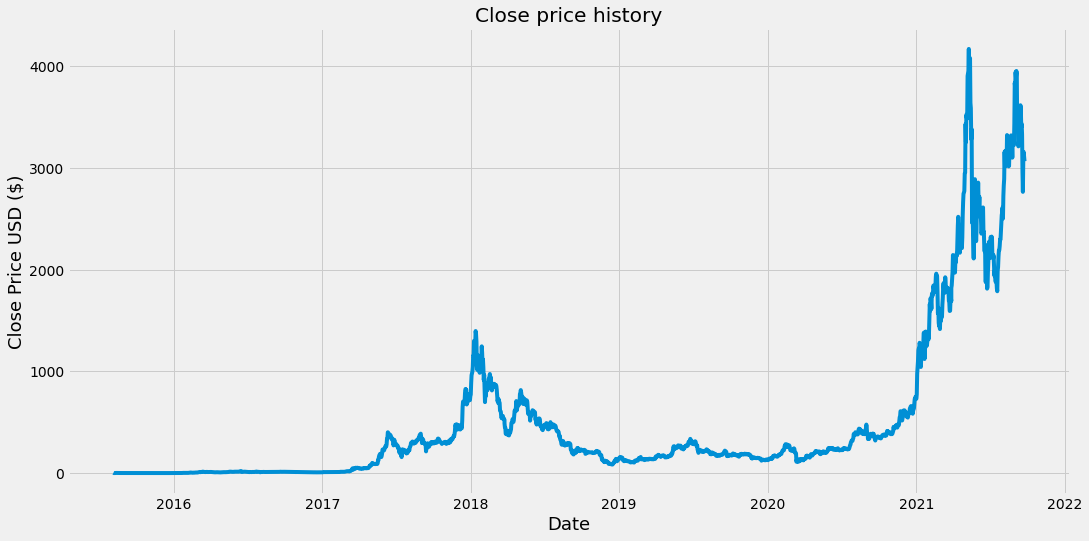

In [4]:
plt.figure(figsize=(16,8))
plt.title('Close price history')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)

In [5]:
# Create a new dataframe with only the Close column

btc_close=df.filter(['Close'])

#Convert the dataframe to a numpy array

dataset = btc_close.values

# get the number of rows to train the model on

training_data_len = math.ceil(len(dataset) * 0.8)

training_data_len


1790

In [6]:
#Scale the data

scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data


array([[5.60734562e-04],
       [7.64097019e-05],
       [6.40717283e-05],
       ...,
       [7.38300492e-01],
       [7.56930722e-01],
       [7.35376966e-01]])

In [7]:
#create the training data set
#Create the scaled data set

train_data = scaled_data[0:training_data_len,:]
#Split the data into x_train and y_train data sets

x_train = []
y_train = []

for i in range (100,len(train_data)):
    x_train.append(train_data[i-100:i, 0])
    y_train.append(train_data[i , 0])
    if i<=60:
        print(x_train)
        print(y_train)
        print()
    

In [8]:
#conver the c_train and y_train to numpy arrays


x_train,y_train = np.array(x_train), np.array(y_train)
#Reshape the data
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1690, 100, 1)

In [9]:
#Build the LSTM model
model = Sequential()

model.add(LSTM(50,return_sequences=True, input_shape = (x_train.shape[1],1 )))
model.add(LSTM(50,return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

In [10]:
#compile the model
model.compile(optimizer='adam',loss='mean_squared_error')


In [11]:
#train the model
model.fit(x_train,y_train,batch_size=1,epochs=1)

1690/1690 [==============================] - 36s 21ms/step - loss: 2.9933e-04


In [12]:
#Create the testing data set
#Create a new array containing scaled values from index 1543 to 2003

test_data = scaled_data[training_data_len - 100 : ,:]
#Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range (100,len(test_data)):
    x_test.append(test_data[i-100:i, 0])
    

In [13]:
#convert the data to numpy array 

x_test = np.array(x_test)
type(x_test)

numpy.ndarray

In [14]:
#Reshape the Data
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))


In [15]:
#Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)




In [16]:
#Get root mean squared error (RMSE)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

181.5986214110782

C:\Users\JUANDI~1\AppData\Local\Temp/ipykernel_5932/2963163159.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


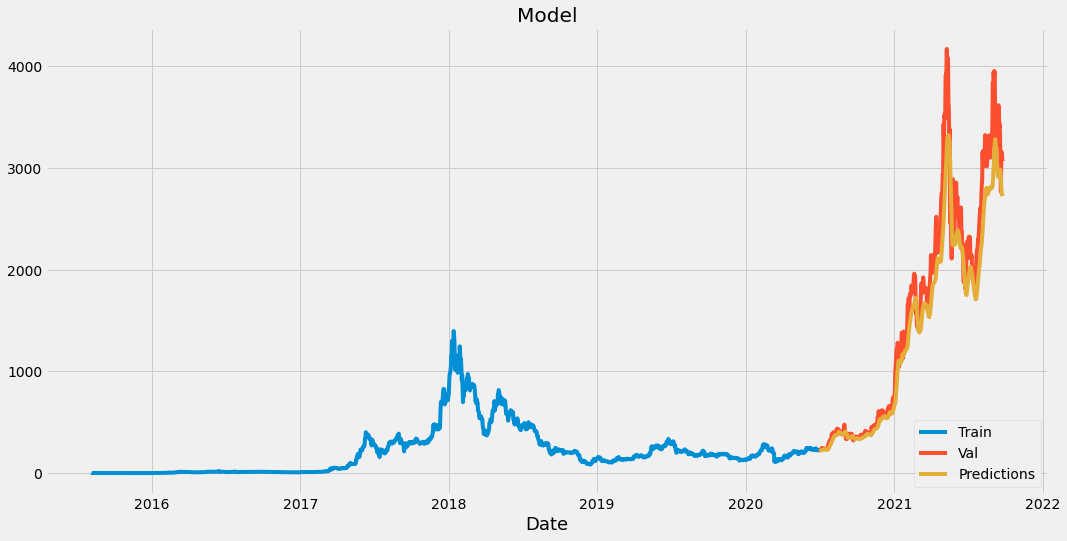

In [17]:
#Plot the data
train = btc_close[:training_data_len]
valid = btc_close[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel=('Close Price USD ($)',18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Val','Predictions'], loc = 'lower right')
plt.show()

In [18]:
#Show the valid and preficted prices
valid

,Close,Predictions
Date,,
2020-07-01,229.392197,223.167465
2020-07-02,225.387070,223.112152
2020-07-03,229.074112,222.750824
2020-07-04,227.664597,222.674728
2020-07-05,241.510223,222.601379
...,...,...
2021-09-19,2958.993408,2971.976074
2021-09-20,2764.431152,2909.100098
2021-09-21,3077.867920,2811.426758


In [27]:
#Get the quote
apple_quote=web.DataReader('ETH-USD',data_source='yahoo',start='2012-01-01',end='2021-09-23')
#create a new Dataframe
new_df = apple_quote.filter(['Close'])
#Get the last 60 day closing price values and convert the dataframe to an array 
last_60_days = new_df[-100:].values
#Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)

#create and empty list

X_test = []
#append the last 60days
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
type(X_test)

numpy.ndarray

In [28]:

X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))


#Get the predicted scaled price

pred_price = model.predict (X_test)

#undo the scaling
pred_price =scaler.inverse_transform(pred_price)
print(pred_price)

[[2703.212]]


In [33]:
apple_quote2=web.DataReader('ETH-USD',data_source='yahoo',start='2021-09-2',end='2021-09-24')
print(apple_quote2['Close'])

KeyError: 'Date'